In [11]:
# Importing libararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, floor
import seaborn as sn

#Reading files
Train_Data = pd.read_csv('Train_Data.csv').values
ds = np.copy(Train_Data)
Train_Labels = pd.read_csv('Train_Labels.csv').values
Test_Data = pd.read_csv('Test_Data.csv').values
Test_Labels = pd.read_csv('Test_Labels.csv').values

print(f"Train_Data shape: {Train_Data.shape}")
print(f"Train_Labels shape: {Train_Labels.shape}")
print(f"Test_Data shape: {Test_Data.shape}")
print(f"Test_Labels shape: {Test_Labels.shape}")
m, n = Train_Data.shape
t, _ = Test_Data.shape

#Number of clusters
k = 10
#Train_Data = Train_Data.reshape((n,m,1))
#Test_Data = Test_Data.reshape((t,m,1))


Train_Data shape: (144, 13)
Train_Labels shape: (144, 1)
Test_Data shape: (32, 13)
Test_Labels shape: (32, 1)


In [2]:
def naive_sharding(ds, k, n, m): 
    centroids = np.mat(np.zeros((k,n)))
    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

def _get_mean(sums, step):
    return sums/step

In [44]:
centroids = naive_sharding(ds, k, n, m)

In [3]:
def Cost(centroids, C, data):
    cost = 0
    m, n = data.shape
    for i in range(m):
        cost = np.sum(np.power(np.subtract(centroids[C[i,0],:], data[i,:]), 2))
    return cost

def CL(Train_Data, centroids):
    m, n = Train_Data.shape
    Distances = np.array([]).reshape(m,0)
    for i in range(k):
        tempDist = np.sum(np.power(np.subtract(Train_Data, centroids[i,:]), 2), axis = 1)
        Distances = np.c_[Distances, tempDist]
    C = np.argmin(Distances, axis = 1)
    C.astype(int)
    return C

In [56]:
Distances = np.array([]).reshape(m,0)
for i in range(k):
    tempDist = np.sum(np.power(np.subtract(Train_Data, centroids[i,:]), 2), axis = 1)
    Distances = np.c_[Distances, tempDist]
C = np.argmin(Distances, axis = 1)
C.astype(int)
print(C.shape)

(144, 1)


In [4]:
N = 10
K = np.arange(1,12)
cost_arr = np.zeros((len(K),N+1))
k_err = np.zeros(len(K))

for t in range(len(K)):
    k = K[t]
    ds = np.copy(Train_Data)
    centroids = naive_sharding(ds, k, n, m)
    C = CL(Train_Data, centroids)
    cost_arr[t][0] = Cost(centroids, C, Train_Data)
    for itera in range(N):
        clusters = [[] for i in range(k)]
        nums = np.zeros(k)
        for i in range(m):
            clusters[C[i,0]].append(i)
            nums[C[i,0]] += 1
        for i in range(k):
            s = np.zeros((1, n))
            for j in range(len(clusters[i])):
                s += Train_Data[clusters[i][j],:]
            centroids[i,:] = s/nums[i]
        C = CL(Train_Data, centroids)
        cost_arr[t][itera + 1] = Cost(centroids, C, Train_Data)
    k_err[t] = cost_arr[t][N-1]

[307147.15229714  30185.44030576   7946.85144457   3782.4300385
   2618.16178302   3598.744609     3598.744609     3598.744609
   3598.744609      864.78608163    864.78608163]


Text(0, 0.5, 'cost')

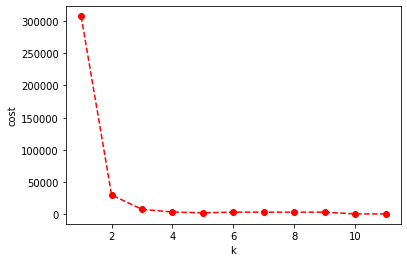

In [5]:
#elbow
print(k_err)
plt.plot(K, k_err,'--ro')
plt.xlabel('k')
plt.ylabel('cost')

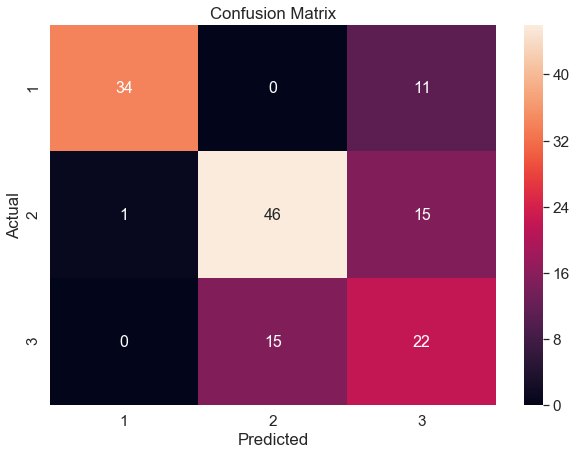

In [37]:
#Optimal k using elbow
k = 3
ds = np.copy(Train_Data)
centroids = naive_sharding(ds, k, n, m)
C = CL(Train_Data, centroids)
for itera in range(N):
    clusters = [[] for i in range(k)]
    nums = np.zeros(k)
    for i in range(m):
        clusters[C[i,0]].append(i)
        nums[C[i,0]] += 1
    for i in range(k):
        s = np.zeros((1, n))
        for j in range(len(clusters[i])):
            s += Train_Data[clusters[i][j],:]
        centroids[i,:] = s/nums[i]
    C = CL(Train_Data, centroids)

U = clusters.copy()
for i in range(k):
    for j in range(len(clusters[i])):
        U[i][j] = Train_Labels[clusters[i][j]][0]

classes = [0 for x in range(k)]
for i in range(k):
    L, counts = np.unique(U[i], return_counts=True)
    counts = np.asarray(counts)
    L = np.asarray(L)
    M = np.argmax(counts)
    classes[i] = L[M]

confusion = [[0 for i in range(k)] for j in range(k)]
for i in range(k):
    for j in range(len(clusters[i])):
        temp = int(U[i][j])-1
        confusion[temp][classes[i]-1] += 1
df_cm = pd.DataFrame(confusion, range(1,k+1), range(1,k+1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
    

In [132]:
Output={}
k = 2
b = np.mat([[1,2,5],
            [1,1,3]])
a = np.mat([[1,2,5],
            [5,8,1],
            [4,1,10]])
A = np.array([]).reshape(3,0)
for i in range(k):
    tempDist = np.sum(np.power(np.subtract(a, b[i,:]), 2), axis = 1)
    A = np.c_[A, tempDist]
C = np.argmin(A, axis = 1) + 1
print(A)
print(C)

[[ 0.  5.]
 [68. 69.]
 [35. 58.]]
[[1]
 [1]
 [1]]


In [116]:
a = np.mat([[1,2,5],
            [5,8,1],
            [4,1,2]])
print(a)
b = np.mat([[1,2,5],
            [1,1,3]])
print(b.shape)
t = np.sum(np.power(np.subtract(a,b), 2), axis = 1)
t.shape

[[1 2 5]
 [5 8 1]
 [4 1 2]]
(1, 3)


(3, 1)

In [29]:

a = [[0 for i in range(k)] for j in range(k)]
a[0][0]=1
a

[[1, 0, 0], [0, 0, 0], [0, 0, 0]]